In [1]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
from scipy.stats import jarque_bera
from scipy.stats import norm
from scipy.stats import f
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import seaborn as sns

In [2]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
sp500 = pdr.get_data_yahoo(ticker, start=datetime.date(2000, 1, 1))["Close"]

# ^OEX is S&P 100.
ticker = "^OEX"
sp100 = pdr.get_data_yahoo(ticker, start=datetime.date(2000, 1, 1))["Close"]

# Convert prices to log returns
sp500_logreturns = np.log(sp500/sp500.shift(1))[1:]
sp100_logreturns = np.log(sp100/sp100.shift(1))[1:]

In [4]:
# Calculate the mean and standard deviation (mostly for comparison's sake later)
mu = sp500_logreturns.mean()
sigma = sp500_logreturns.std()
print("Mean is: ", mu)
print("Standard deviation is: ", sigma)

Mean is:  0.00015385060232619044
Standard deviation is:  0.012578240847020864


In [5]:
# Calculate skew and kurtosis
print("Skew is: ", sp500_logreturns.skew()) # left tail of the distribution is longer 
print("Kurtosis is: ", sp500_logreturns.kurtosis()) # STYLIZED FACT: fat tails, high peak (high kurtosis)

Skew is:  -0.3896442890126872
Kurtosis is:  10.997676824973174


Text(0.5, 1.0, 'Q-Q plot')

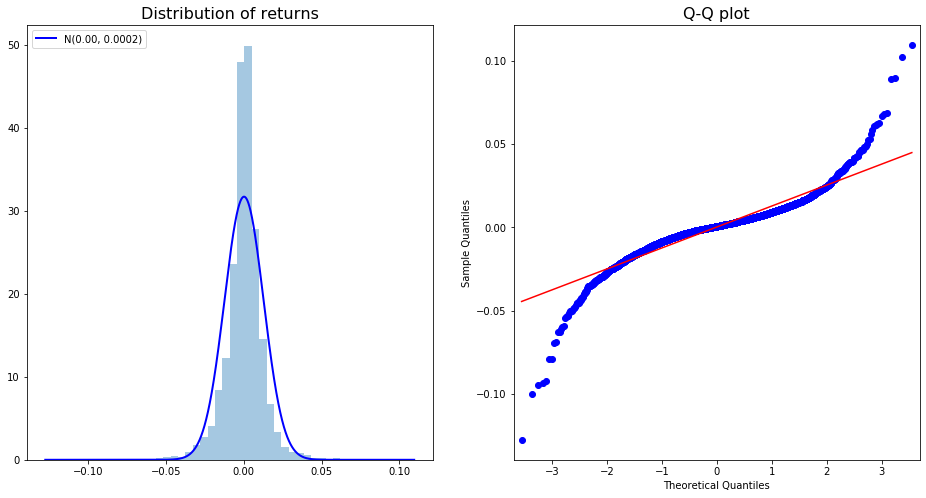

In [6]:
plot_range = np.linspace(min(sp500_logreturns), max(sp500_logreturns), num=5000 )
pdf_series = norm.pdf(plot_range, loc=mu, scale=sigma)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Histogram
sns.distplot(sp500_logreturns.values, kde=False, norm_hist=True, ax=ax[0]) # STYLIZED FACT: high peak

ax[0].set_title('Distribution of returns', fontsize=16)
ax[0].plot(plot_range, pdf_series, 'b', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left')

# QQ Plot
qq = sm.qqplot(sp500_logreturns.values, line='s', ax=ax[1]) # STYLIZED FACT: fat tails
ax[1].set_title('Q-Q plot', fontsize = 16)

In [7]:
# Perform Jarque-Bera test
"""
H_0 : distribution is normal at 99% confidence level
H_1 : distribution is not normal at 99% confidence level

- checks whether a distribution has skewness and kurtosis values matching that of a normal distribution
- result is a non-negative value - the farther from zero, the greater it deviates from normal distribution
"""
value = jarque_bera(sp500_logreturns)[0]
p_value = jarque_bera(sp500_logreturns)[1]
print("The Jarque-Bera test statistic value is", value, "with probability of", p_value) # STYLIZED FACT: not a normal distribution

The Jarque-Bera test statistic value is 26352.155634325365 with probability of 0.0


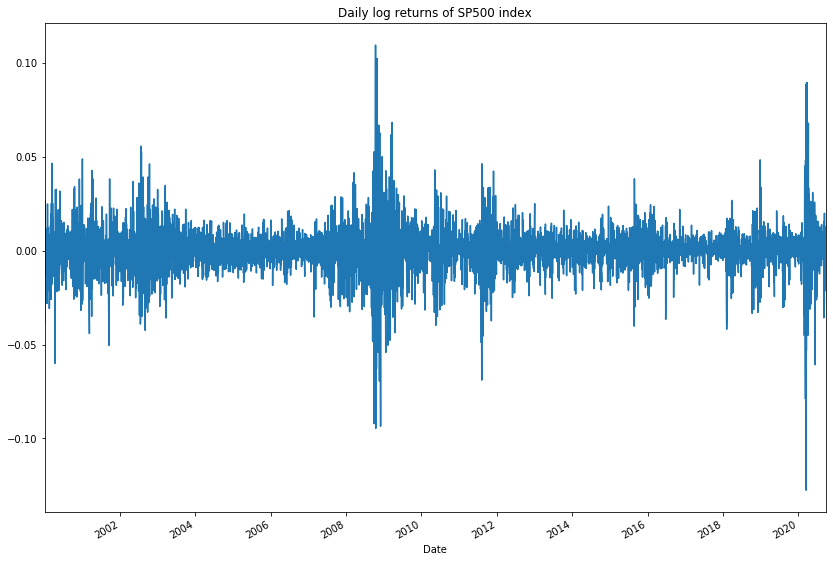

In [8]:
# STYLIZED FACT: volatility clustering
sp500_logreturns.plot(title = 'Daily log returns of SP500 index', figsize = (14,10))

In [9]:
# STYLIZED FACT: leverage effect
# i.e. the volatility of asset returns is negatively correlated with the return process

window_size = 21
vol = sp500_logreturns.rolling(window_size).std()
vol[window_size:].corr(sp500_logreturns[window_size:])

-0.003681753449499214

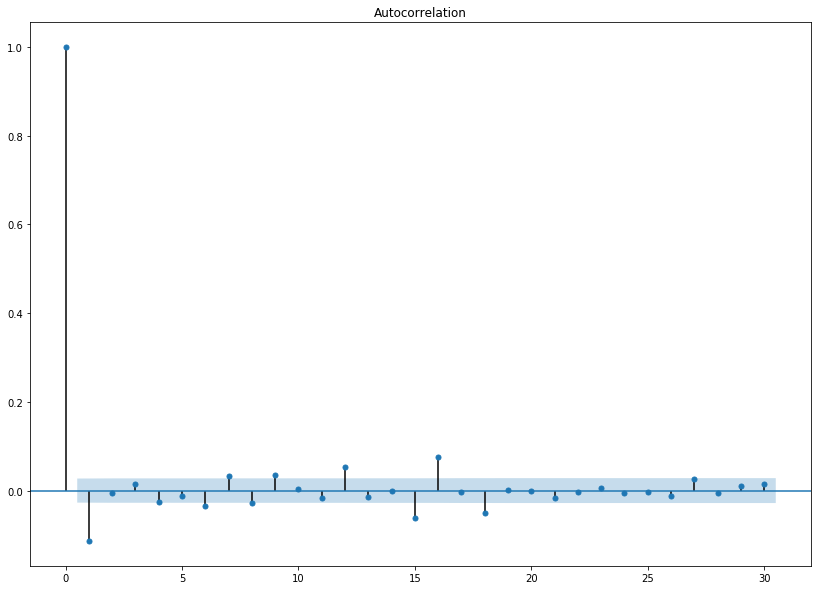

In [39]:
# STYLIZED FACT: There is no autocorrelation in returns
# Most autocorrelation values lie within the confidence interval, hence minimal autocorrelation
# Autocorrelation values become smaller with increasing lag

# Setting lags to 30, significance level to 0.05, confidence level to 0.95
fig, ax = plt.subplots(figsize=(14, 10))
acf = smt.graphics.plot_acf(sp500_logreturns, lags=30, alpha=0.05, ax = ax)

[Text(0, 0.5, 'Absolute Log Returns'),
 Text(0.5, 0, 'Lag'),
 Text(0.5, 1.0, 'Autocorrelation plots of absolute log returns')]

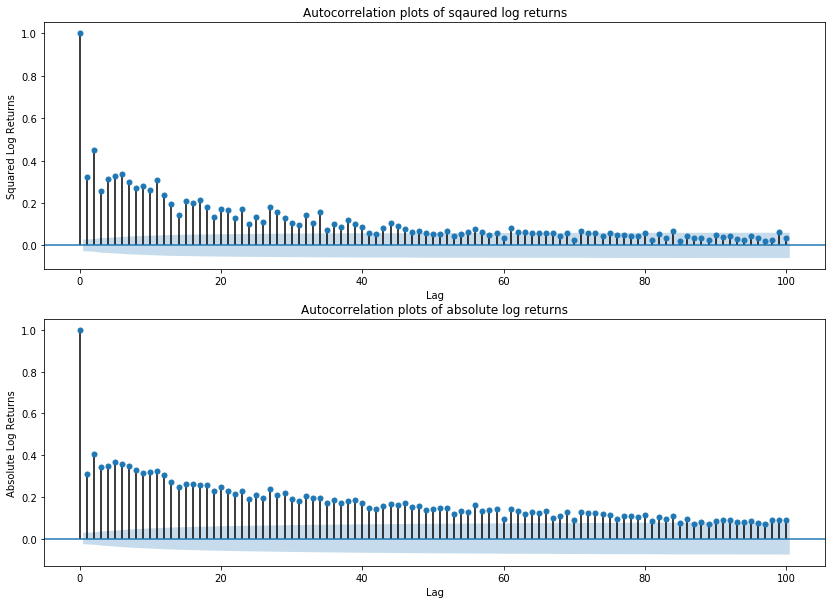

In [47]:
# STYLIZED FACT: There is a decreasing autocorrelation trend in squared/absolute returns
# Creating the acf plots for squared and absolute returns
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Using statsmodels library to obtain acf plot for squared returns
smt.graphics.plot_acf(sp500_logreturns ** 2, lags=100, alpha=0.05, ax = ax[0])

# Setting title, y-axis labels and x-axis labels of first subplot 
ax[0].set(title='Autocorrelation plots of sqaured log returns', ylabel='Squared Log Returns', xlabel='Lag')

# Obtaining acf plot of absolute returns using abs function of numpy library
smt.graphics.plot_acf(np.abs(sp500_logreturns), lags=100, alpha=0.05, ax = ax[1])

# Setting title, y-axis labels and x-axis labels of second subplot 
ax[1].set(title='Autocorrelation plots of absolute log returns', ylabel='Absolute Log Returns', xlabel='Lag')

In [64]:
# This might be wrong... should double check
def variance_ratio(ts, lag = 2):
    """
    Returns the variance ratio test result
    """
    n = len(ts)
    ts = np.asarray(ts)
    x = np.array(ts[1:n]-ts[:n-1])
    y = np.array(ts[lag:n]-ts[:n-lag])
    f_stat = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-f.cdf(f_stat, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [67]:
# If we assume the data follow a random walk, the variance of a q-period difference should be q times the variance of the one-period difference
variance_ratio(sp500_logreturns)[1] #reject null hypothesis that data is a random walk!

0.00011319079744476213

In [65]:
# Kolmogorov-Smirnov test (KS test) 
# test the null hypothesis that each generated path is drawn from the same distribution as the historical daily returns
# for now, use sp100 index as a placeholder
ks_2samp(np.asarray(sp500_logreturns), np.asarray(sp100_logreturns))

Ks_2sampResult(statistic=0.006331542594013815, pvalue=0.9999425824169829)

In [66]:
# Earth Moverâ€™s Distance 
# measure the distance between two distributions
# i.e. the amount of mass needed to move to make the distributions the same
wasserstein_distance(np.asarray(sp500_logreturns), np.asarray(sp100_logreturns))

0.00011091333069700198